# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [2]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'1.0.5'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [4]:
import os
DayFolder=os.getcwd()

if os.name=='posix':
    slash='/'
else:
    slash='\\'

meta_path=DayFolder +slash+ 'MetaData'
spectra_path=DayFolder +slash+ 'Spectra'

# Filetype and extension for spectra
spectra_filetype='headless_txt'
spectra_file_ext='.txt'
# file extension for spectra
meta_file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
# If so - what is the character separating the prefix from the real name
prefix_str=' '
# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, spectra_filetype, prefix, prefix_str, spectra_file_ext, meta_file_ext, TruPower)


Good job! Filetype headless_txt is valid.


In [5]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad','Series'], sort=False)

Ne_files

['01 Ne1.txt',
 '02 Ne2.txt',
 '20 Ne3.txt',
 '32 Ne4.txt',
 '42 Ne5.txt',
 '51 Ne6.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [6]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.iloc[1:7]

,Raman_shift (cm-1),Intensity,Ne emission line in air
15,818.699523,5000.0,556.27662
23,1117.086987,5000.0,565.66588
30,1310.480205,5000.0,571.92248
33,1398.915133,5000.0,574.82985
37,1447.564622,7000.0,576.44188
40,1567.204978,5000.0,580.44496


### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [7]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

,Ne_Split,Line_1,Line_2,Line_1_int,Line_2_int,Entered Pos Line 1,Entered Pos Line 2
0,330.477634,1117.086987,1447.564622,5000.0,7000.0,1117,1447


## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [8]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

,Peak1_cent,Peak1_height,Peak2_cent,Peak2_height,Peak1_prom,Peak2_prom
0,1116.692052,3752.666748,1447.608312,47524.0,3043.500098,46814.83335


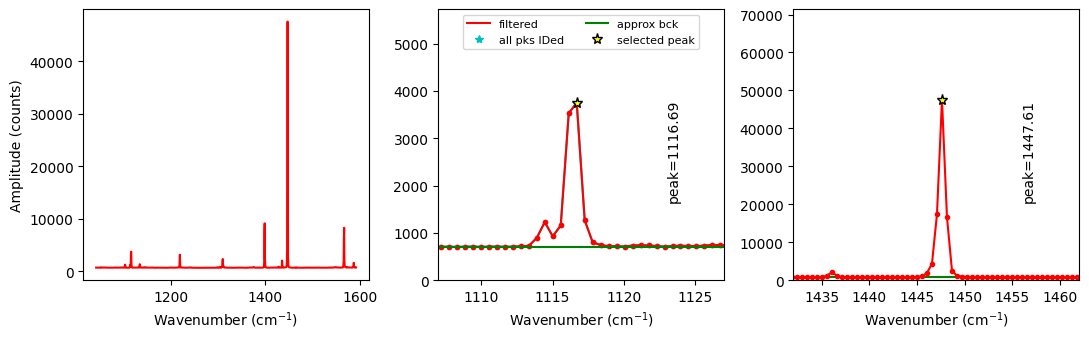

In [9]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=spectra_filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [10]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, peaks_2=1, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), LH_offset_mini2=None, x_span_pk1=None, x_span_pk2=None)

In [11]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

,filename,1σ_Ne_Corr_test,1σ_Ne_Corr,pk2_peak_cent,pk2_amplitude,pk2_sigma,pk2_gamma,error_pk2,Peak2_Prop_Lor,pk1_peak_cent,...,Peak1_Prop_Lor,deltaNe,Ne_Corr,Ne_Corr_min,Ne_Corr_max,residual_pk2,residual_pk1,residual_pk1+pk2,error_pk1_amplitude,error_pk2_amplitude
0,Ne1.txt,0.000033,0.000033,1447.599281,47715.921085,0.41531,None,0.002152,0.41157,1116.434989,...,0.2221,331.164291,0.997927,0.997887,0.997966,139.070876,11.369985,150.440861,213.008735,345.465809


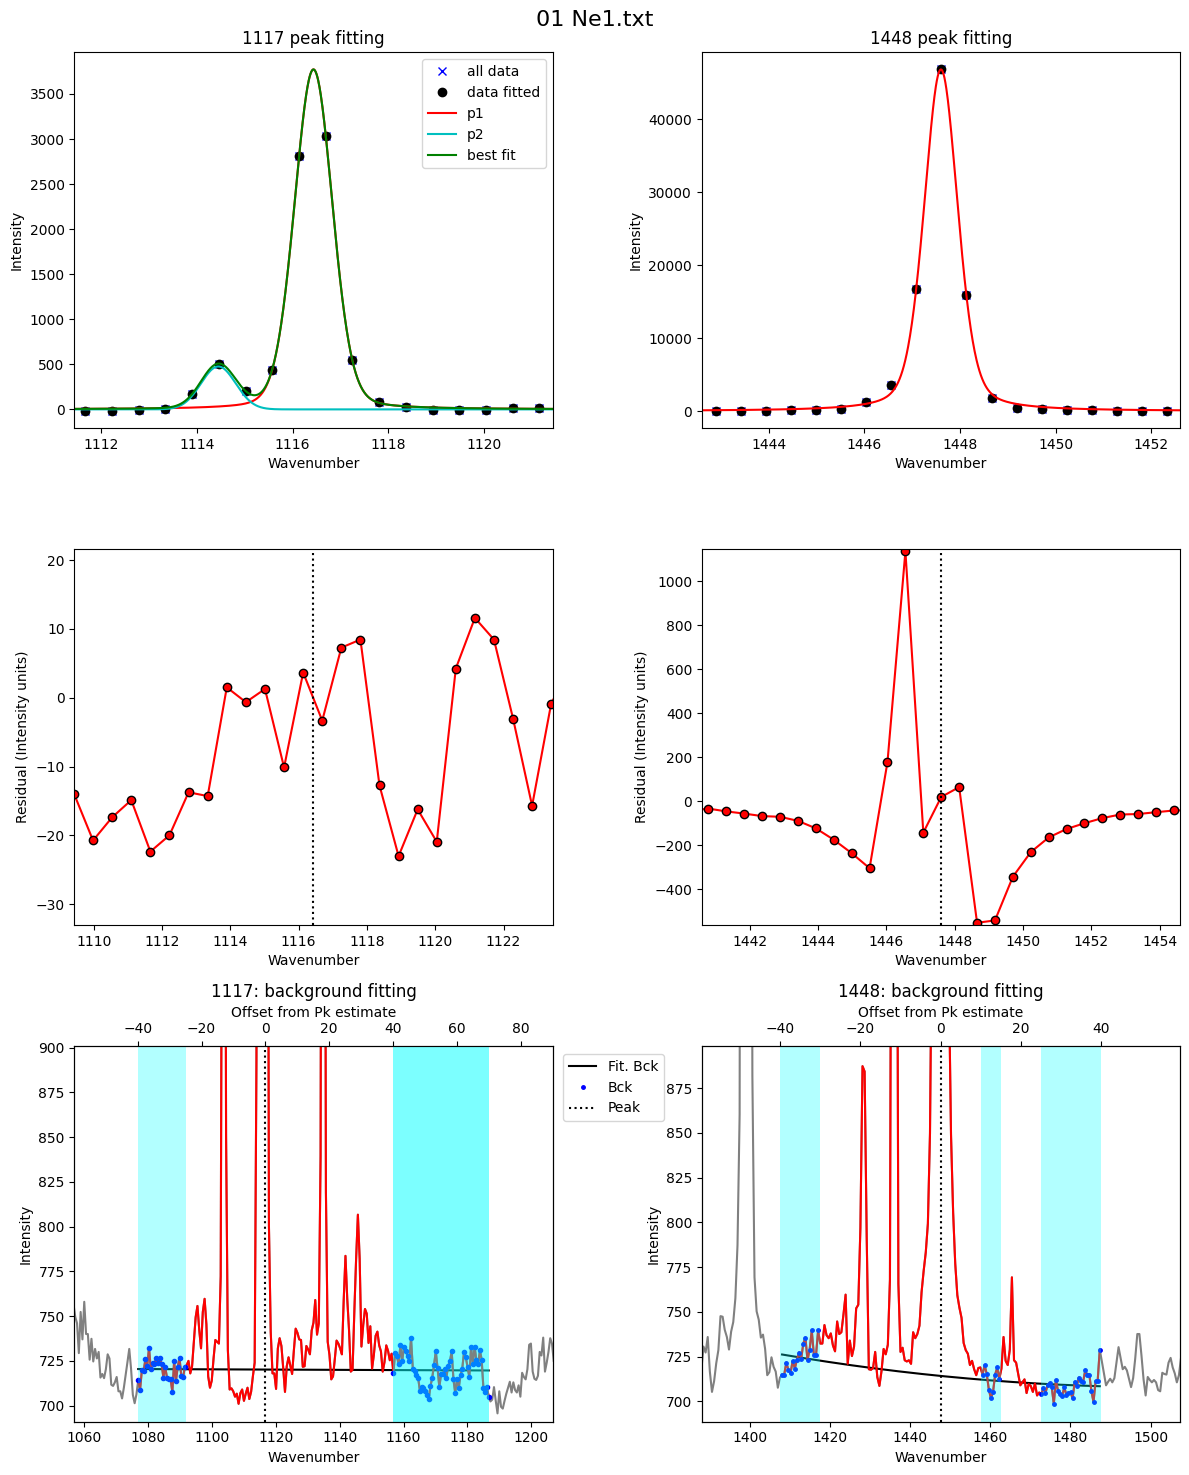

In [12]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [13]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/6 [00:00<?, ?it/s]

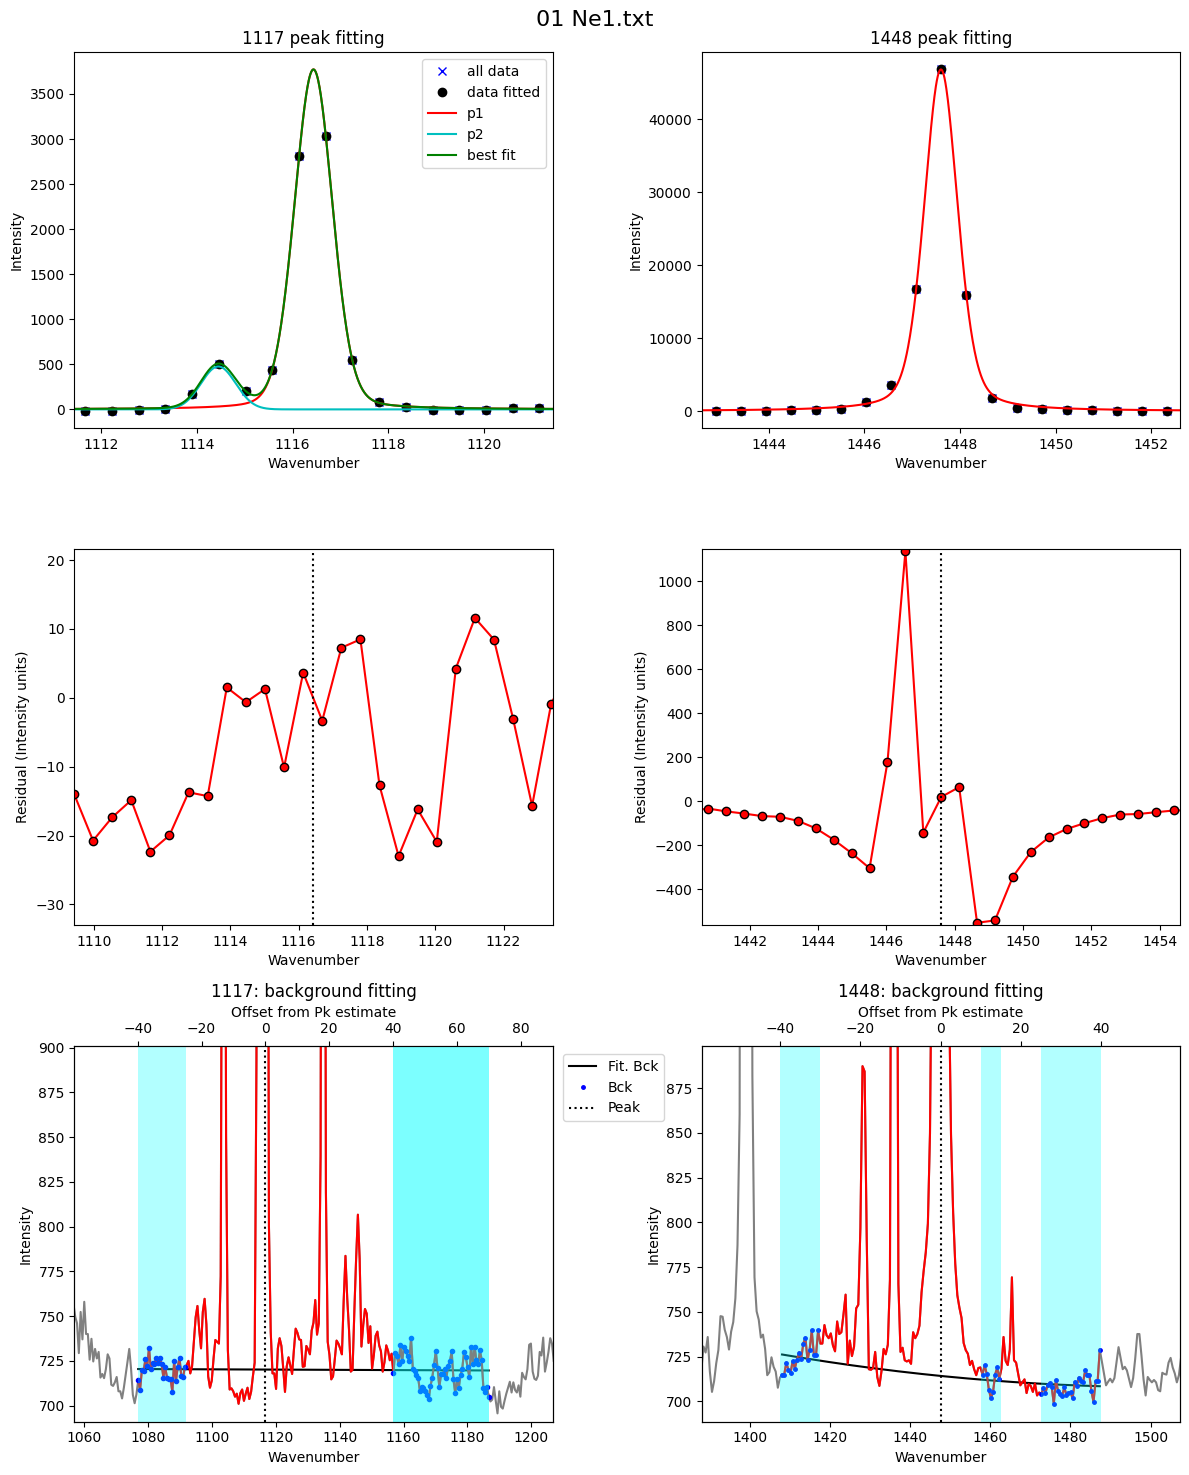

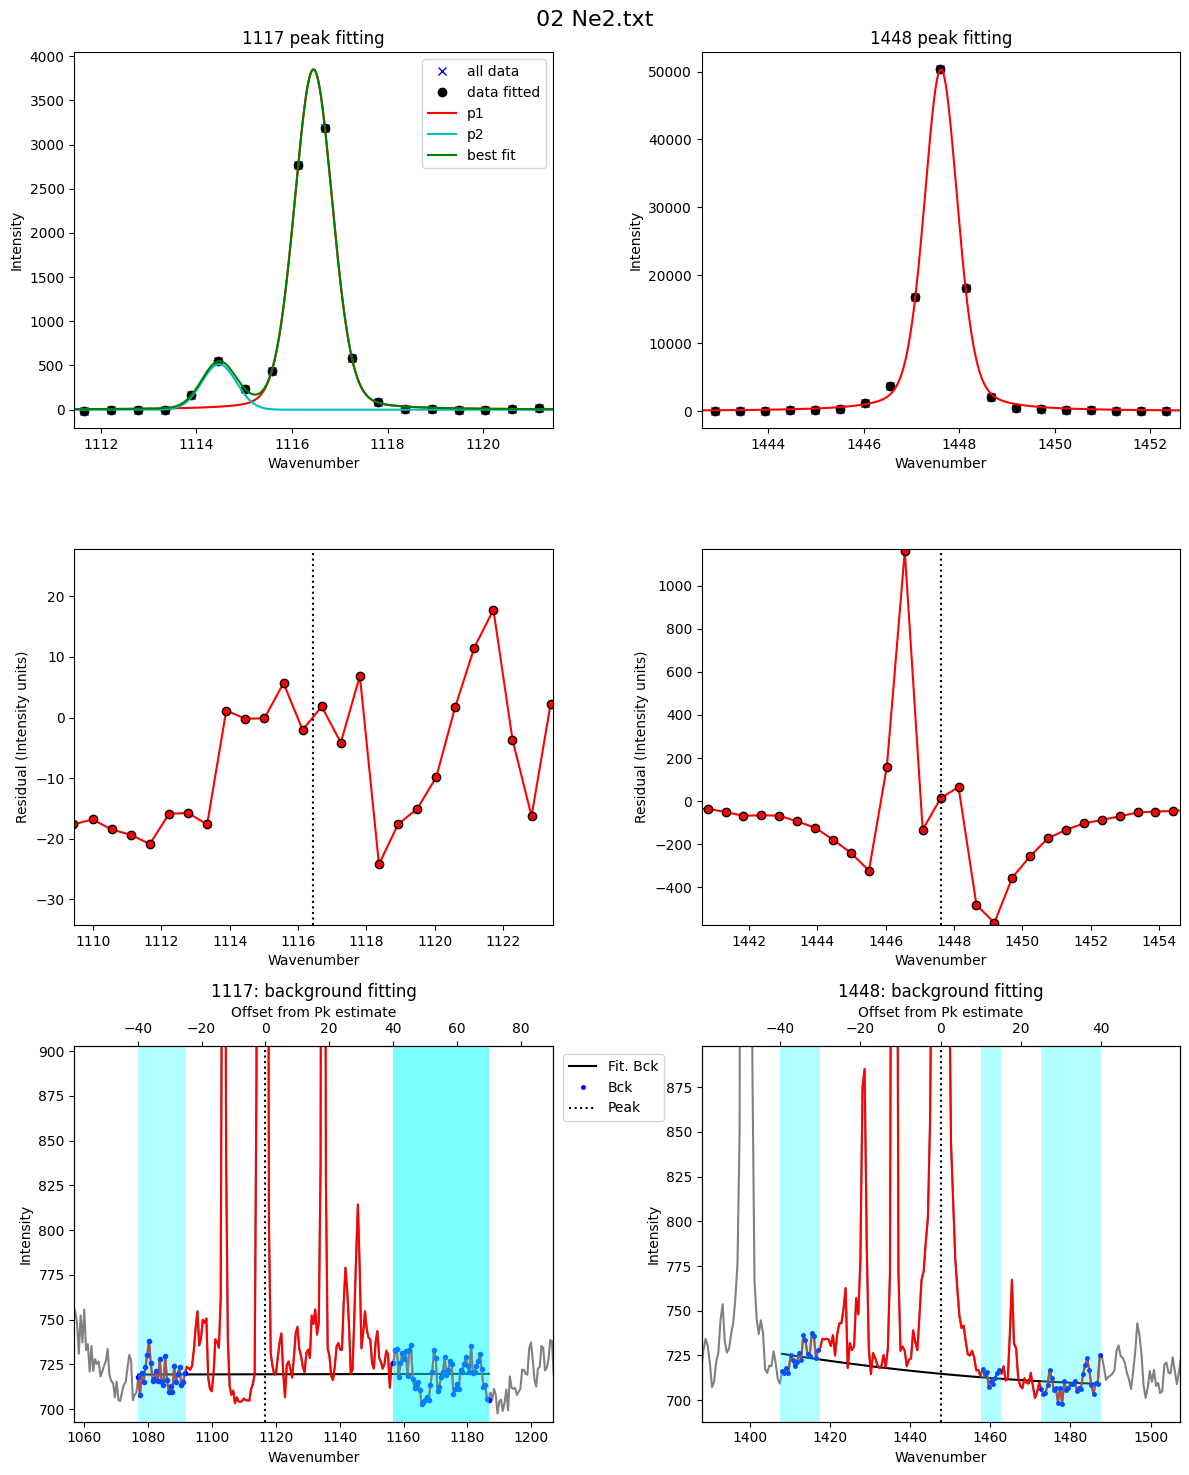

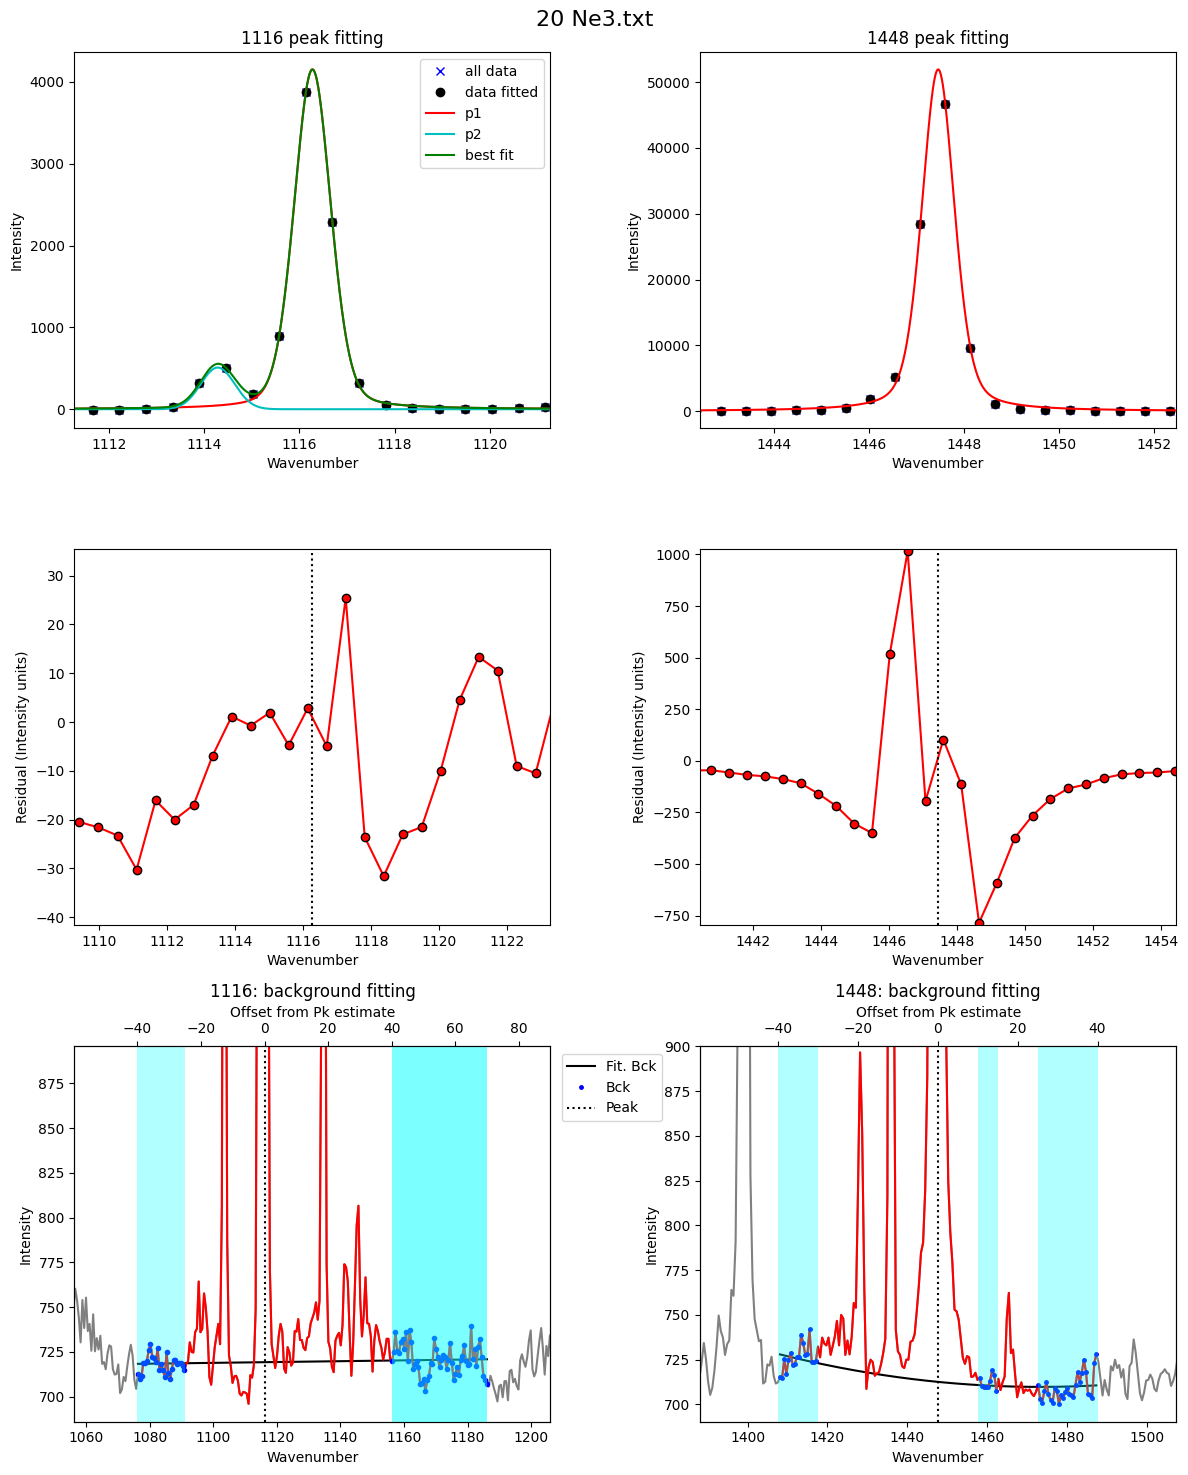

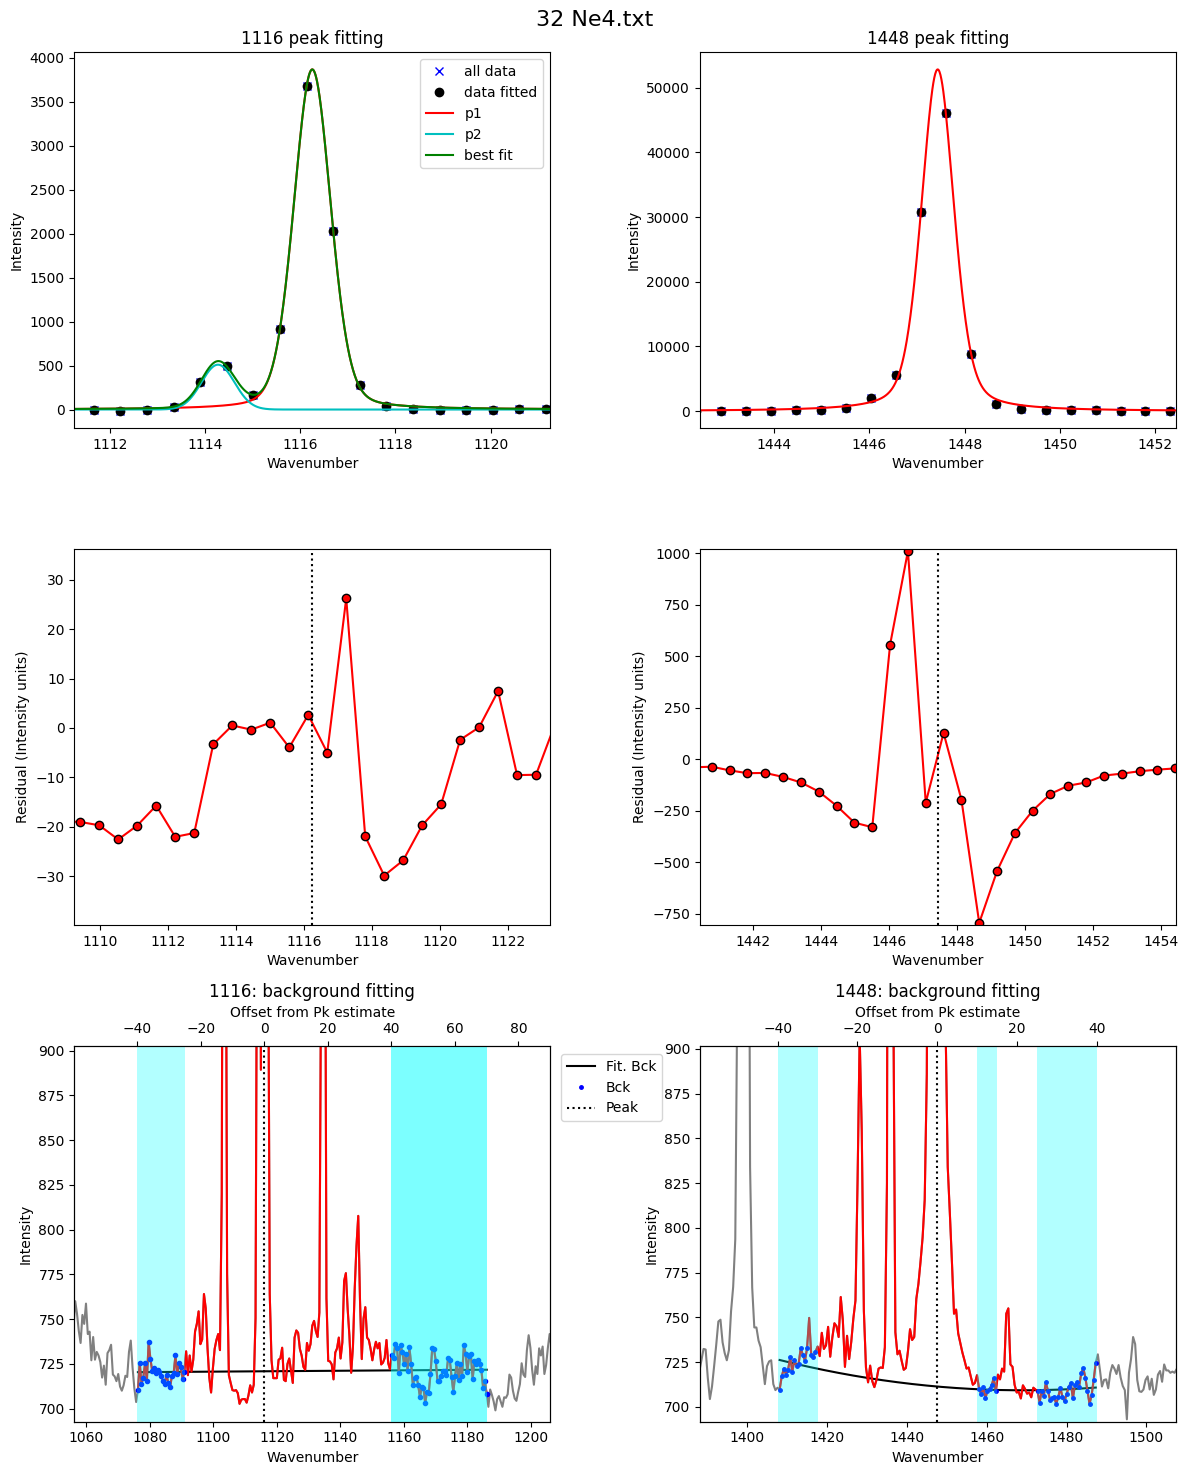

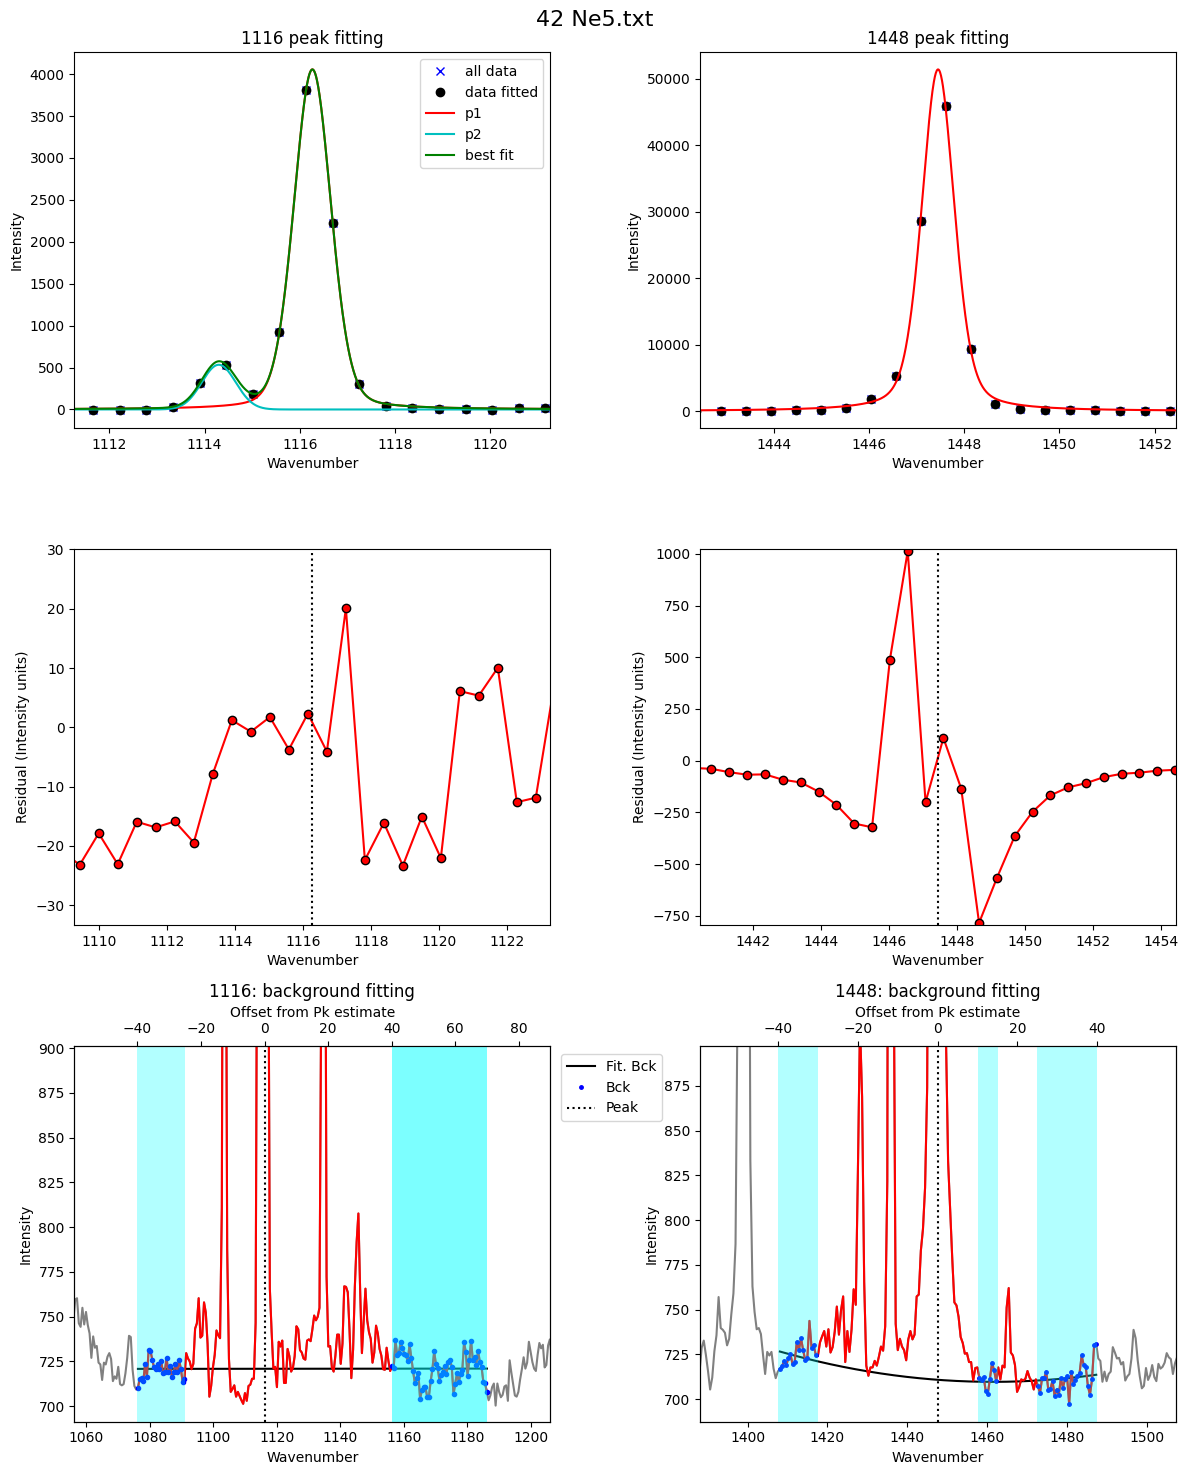

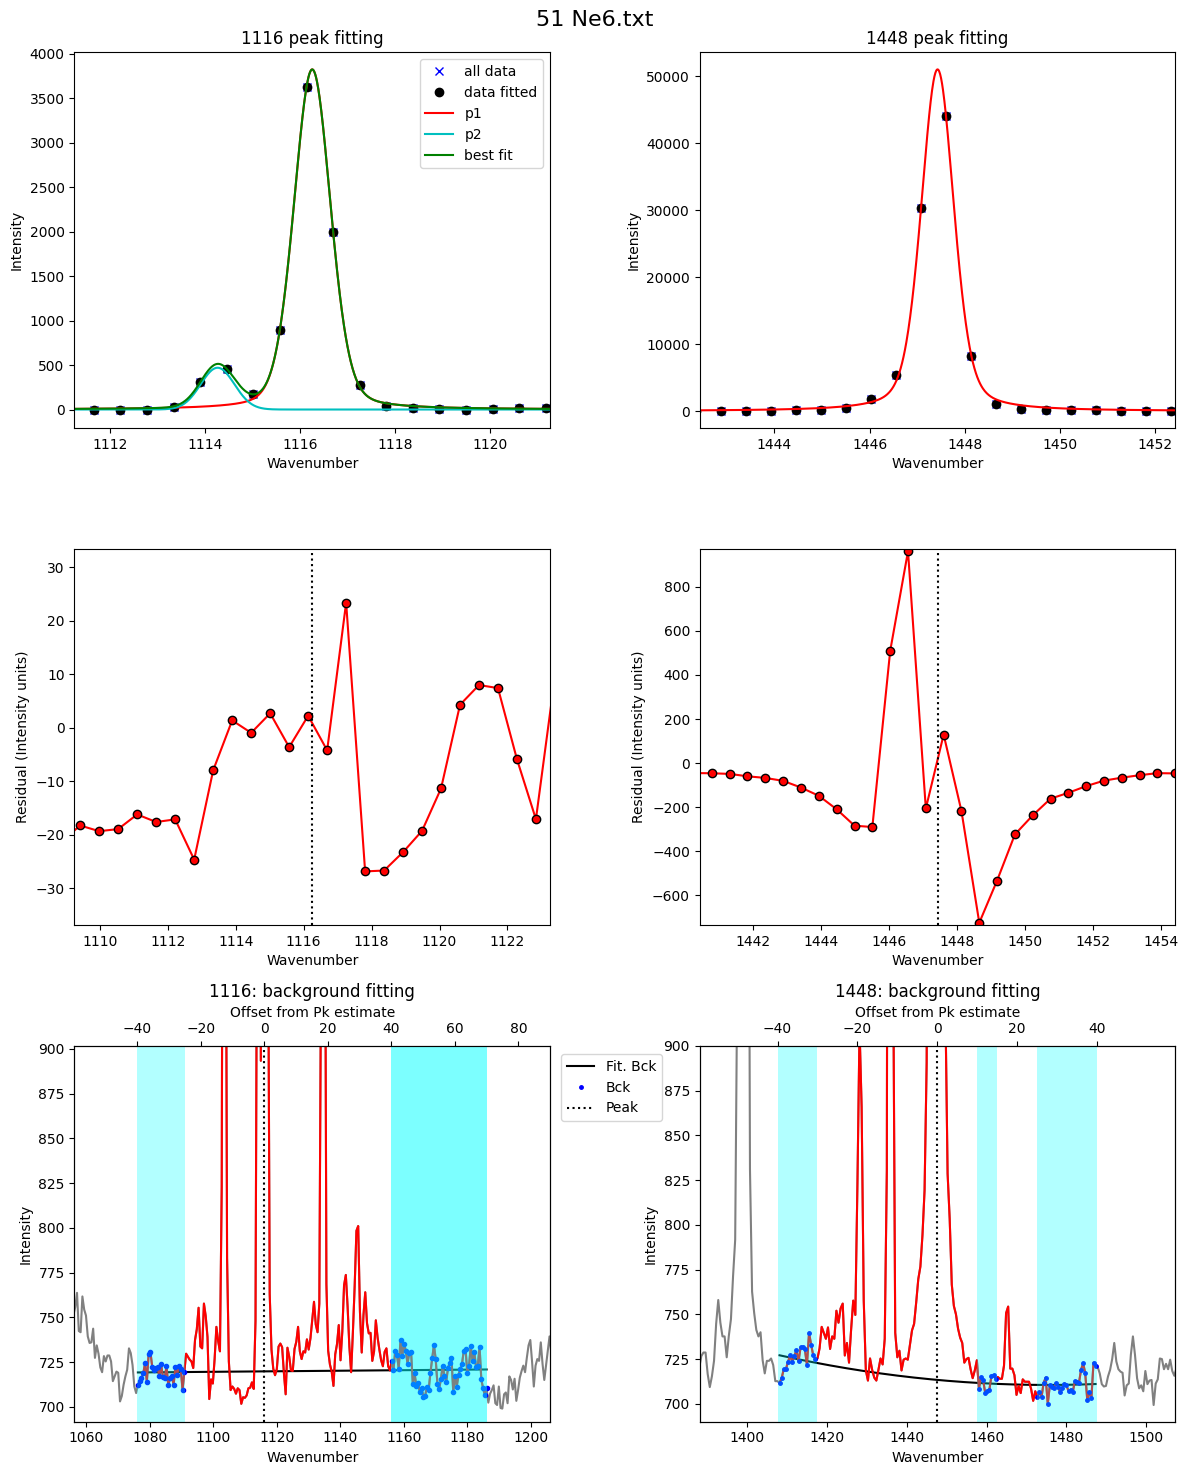

In [14]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=spectra_filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [15]:
df2

,filename,Ne_Corr,1σ_Ne_Corr,deltaNe,pk2_peak_cent,pk1_peak_cent,pk2_amplitude,pk1_amplitude,residual_pk2,residual_pk1,...,Peak2_Prop_Lor,pk1_sigma,pk1_gamma,error_pk1,Peak1_Prop_Lor,Ne_Corr_min,Ne_Corr_max,residual_pk1+pk2,error_pk1_amplitude,error_pk2_amplitude
0,Ne1.txt,0.997927,0.000033,331.164290,1447.599281,1116.434991,47715.928774,4053.132379,139.071139,11.368111,...,0.411571,0.468549,None,0.010814,0.221950,0.997887,0.997966,150.439250,213.008778,345.464377
1,Ne2.txt,0.997920,0.000033,331.166507,1447.617613,1116.451105,51082.195404,4150.497460,141.284813,11.180730,...,0.399541,0.469502,None,0.010584,0.226312,0.997882,0.997958,152.465543,203.254202,344.522535
2,Ne3.txt,0.997869,0.000036,331.183449,1447.456075,1116.272625,52198.672349,4441.485637,168.554765,13.615994,...,0.442057,0.454281,None,0.011718,0.297828,0.997827,0.997911,182.170759,179.537337,391.470833
3,Ne4.txt,0.997870,0.000038,331.183045,1447.435151,1116.252106,53032.144218,4147.797342,168.656700,12.817224,...,0.434651,0.458145,None,0.012413,0.279313,0.997826,0.997914,181.473925,177.055310,395.822327
4,Ne5.txt,0.997866,0.000036,331.184439,1447.450933,1116.266494,51670.567431,4348.731228,162.967780,12.913440,...,0.436403,0.460172,None,0.011623,0.267839,0.997824,0.997907,175.881220,176.558418,387.255036
5,Ne6.txt,0.997892,0.000040,331.175699,1447.428939,1116.253241,51143.801988,4108.336021,159.887665,12.979071,...,0.427998,0.455150,None,0.013021,0.305314,0.997847,0.997938,172.866735,181.068077,402.417083


## Now extract metadata to get a timestamp for each file

In [16]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['001 Ne1.txt', '002 Ne2.txt', '039 Ne3.txt', '063 Ne4.txt', '098 Ne5.txt']

In [17]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 6/6 [00:00<00:00,  7.85it/s]

Done


,filename,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,Ne1.txt,"August 30, 2024\n",August,30.0,6.024,45.0,3.0,50.0,"['0h', '2m', '16s']",12:51:58 PM\n,46318.0,1324.964
1,Ne2.txt,"August 30, 2024\n",August,30.0,6.046,45.0,3.0,50.0,"['0h', '2m', '16s']",1:26:27 PM\n,48387.0,1324.964
2,Ne3.txt,"August 30, 2024\n",August,30.0,11.948,45.0,3.0,50.0,"['0h', '2m', '17s']",3:09:35 PM\n,54575.0,1324.964
3,Ne4.txt,"August 30, 2024\n",August,30.0,5.991,45.0,3.0,50.0,"['0h', '2m', '17s']",4:26:42 PM\n,59202.0,1324.964
4,Ne5.txt,"August 30, 2024\n",August,30.0,5.984,45.0,3.0,50.0,"['0h', '2m', '17s']",5:21:01 PM\n,62461.0,1324.964


In [18]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext=meta_file_ext)
file_m

good job, no duplicate file names


array(['Ne1', 'Ne2', 'Ne3', 'Ne4', 'Ne5', 'Ne6'], dtype=object)

In [19]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext=spectra_file_ext)
file_s

good job, no duplicate file names


array(['Ne1', 'Ne2', 'Ne3', 'Ne4', 'Ne5', 'Ne6'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [20]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')
print('Number merged= '+str(len(df_combo))+', Check this is what you expected, else check file_m and file_s look the same')

Number merged= 6, Check this is what you expected, else check file_m and file_s look the same


## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [21]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

In [22]:
0.4/df_combo['error_pk2']

0    185.844770
1    201.222342
2    182.726857
3    194.383370
4    185.730350
5    189.239113
Name: error_pk2, dtype: float64

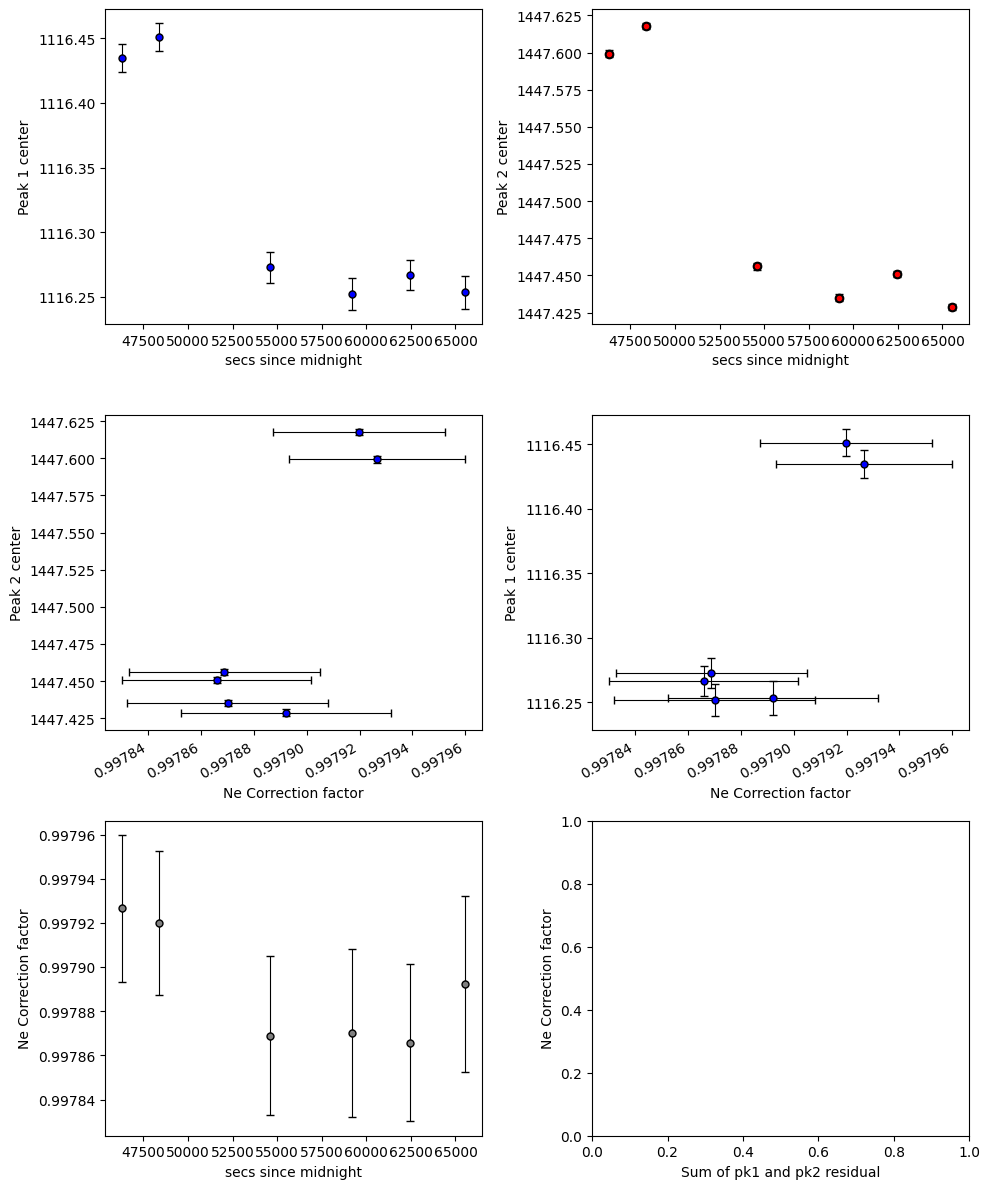

In [23]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [24]:
103.2*0.9979

102.98328000000001

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

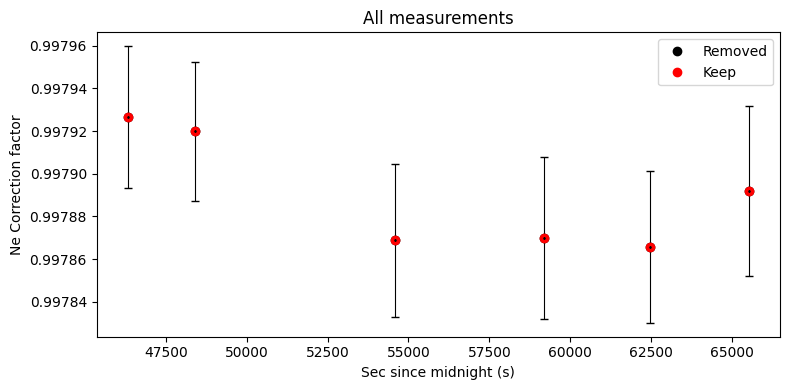

In [25]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

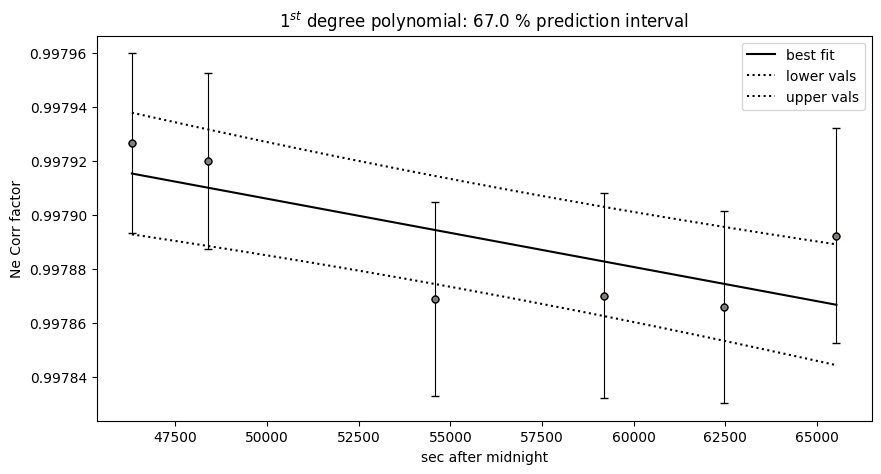

In [26]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=1, CI=0.67, pkl_name='Neon_corr_model.pkl')
